# **Practical Example 1**
## **Semantic Segmentation with tiny encoder-decoder architecture**




### Imports

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
%matplotlib inline

# reproducibility
np.random.seed(0)

### Installation of the cairo library for creating geometric shapes

In [29]:
'''!apt install libcairo2-dev
!pip install pycairo'''
import cairo

## Functions for creating and manipulating the dataset (Dataset functions)

In [30]:
def multiple_shape_dataset(num_imgs = 100, num_objects = 5, img_size = 32, min_object_size = 4, max_object_size = 16):

  imgs = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)  # format: BGRA
  masks = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)  # format: BGRA

  num_shapes = 3
  shape_labels = ['rectangle', 'circle', 'triangle']
  
  num_colors = 3
  color_labels = ['r', 'g', 'b']

  for i_img in range(num_imgs):
    
    # cairo imgs
    surface_img = cairo.ImageSurface.create_for_data(imgs[i_img], cairo.FORMAT_RGB24, img_size, img_size)
    cr_img = cairo.Context(surface_img)
    cr_img.set_source_rgb(0, 0, 0) # Fill background white.
    cr_img.paint()

    # cairo mask
    surface_mask = cairo.ImageSurface.create_for_data(masks[i_img], cairo.FORMAT_RGB24, img_size, img_size)
    cr_mask = cairo.Context(surface_mask)
    cr_mask.get_source().set_extend(cairo.EXTEND_REPEAT)

    cr_mask.set_source_rgb(0, 0, 0) # Fill background black.
    cr_mask.paint()

    # Draw random shapes.
    for i_object in range(num_objects):
      shape = np.random.randint(num_shapes)

      if shape == 0:  # rectangle
          w, h = np.random.randint(min_object_size, max_object_size, size=2)
          x = np.random.randint(0, img_size - w)
          y = np.random.randint(0, img_size - h)

          cr_img.rectangle(x, y, w, h)
          cr_img.set_source_rgb(0.5, 0.1, 0.1) # red

      elif shape == 1:  # circle   
          r = 0.5 * np.random.randint(min_object_size, max_object_size)
          x = np.random.randint(r, img_size - r)
          y = np.random.randint(r, img_size - r)

          cr_img.arc(x, y, r, 0, 2*np.pi)
          cr_img.set_source_rgb(0.1, 0.5, 0.1) # green

      elif shape == 2:  # triangle
          w, h = np.random.randint(min_object_size, max_object_size, size=2)
          x = np.random.randint(0, img_size - w)
          y = np.random.randint(0, img_size - h)

          cr_img.move_to(x, y)
          cr_img.line_to(x+w, y)
          cr_img.line_to(x+w, y+h)
          cr_img.line_to(x, y)
          cr_img.close_path()

          cr_img.set_source_rgb(0.1, 0.1, 0.5) # blue

      cr_img.fill()

  imgs = imgs[..., 2::-1]  # is BGRA, convert to RGB
  masks = getImageLabels(imgs) # generations of masks from images
  imgs = normalize_dataset(imgs) # normalization of pixels values

  return imgs, masks

In [31]:
def getImageLabels(masks):
    
    labels = np.zeros((masks.shape[0], masks.shape[1], masks.shape[2], 4), dtype=np.uint8)

    for i in range(0, masks.shape[0]):
      
      mask_0 = (masks[i] == [  0,  0,  0]).all(axis=2) # backgroud = 0
      mask_1 = (masks[i] >  [100,  0,  0]).all(axis=2) # rectangle = 1
      mask_2 = (masks[i] >  [  0,100,  0]).all(axis=2) # circle    = 2
      mask_3 = (masks[i] >  [  0,  0,100]).all(axis=2) # triangle  = 3
      
      labels[i][mask_0, 0] = 1
      labels[i][mask_1, 1] = 1 
      labels[i][mask_2, 2] = 1
      labels[i][mask_3, 3] = 1
      
    return labels

In [32]:
def normalize_dataset(imgs):
  X = imgs / 255.
  return X

In [33]:
def split_dataset(X, y, train_ratio = 0.8):
  num_imgs = X.shape[0]
  i = int(train_ratio * num_imgs)
  train_X = X[:i]
  test_X = X[i:]
  train_y = y[:i]
  test_y = y[i:]
  return train_X, test_X, train_y, test_y

### Helper functions

In [34]:
def show_image(img):
  plt.figure(figsize=(8,4))
  plt.subplot(1, 2, 1)
  img_size = imgs[0].shape[0]
  plt.imshow(img, interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])

def display_mask(mask):
  mask = np.argmax(mask, axis=-1) # (32, 32, n_classes) > (32, 32)
  plt.imshow(np.squeeze(mask), cmap="Greys", interpolation='none', origin='lower', extent=[0, 32, 0, 32])

def display(imgs, masks):
  img_size = imgs[0].shape[0]
  plt.figure(figsize=(16, 8))

  for i, i_subplot in enumerate(range(1, 5)):
    plt.subplot(2, 4, i_subplot)
    plt.imshow(imgs[i], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])

  for i, i_subplot in enumerate(range(5, 9)): 
    plt.subplot(2, 4, i_subplot)
    mask = np.argmax(masks[i], axis=-1) 
    plt.imshow(np.squeeze(mask), cmap="Greys", interpolation='none', origin='lower', extent=[0, 32, 0, 32])

    plt.axis('off')

  plt.show()

In [35]:
# create dataset
imgs, masks = multiple_shape_dataset(num_imgs = 5000, num_objects = 5, img_size = 32, min_object_size = 4, max_object_size = 16)

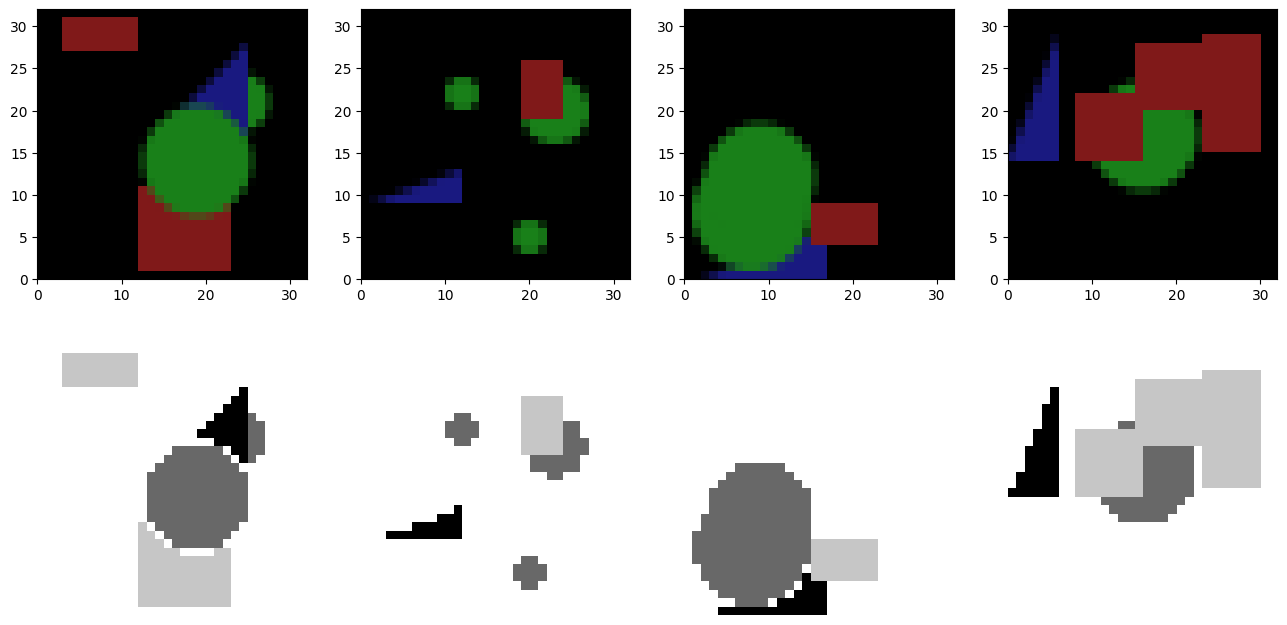

In [36]:
display(imgs, masks)

## Model definition and configuration

In [37]:
# import libs
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Add, Activation, Dropout, Convolution2D, Conv2D, MaxPooling2D, Flatten, Conv2DTranspose, Reshape, Lambda, concatenate

import tensorflow.keras.backend as K
K.backend()

'tensorflow'

In [38]:
#build the model
def model_segmentation(n_classes, img_shape):
    model = Sequential()

    inputs = Input(shape=img_shape) ## 224,224,3 ## 

    c1 = Conv2D(32, (3, 3), activation='elu', padding='same') (inputs) 
    c1 = Dropout(0.2) (c1)
    c1 = Conv2D(32, (3, 3), activation='elu', padding='same') (c1)

    p1 = MaxPooling2D((2, 2)) (c1) # downsampling

    c2 = Conv2D(64, (3, 3), activation='elu', padding='same') (p1)
    c2 = Dropout(0.4) (c2)
    c2 = Conv2D(64, (3, 3), activation='elu', padding='same') (c2)

    u1 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same') (c2) # upsampling

    u1 = Add()([u1, c1]) # skip connections

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (u1)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)

    output = Conv2D(n_classes, (3, 3), activation='softmax', padding='same')(c3)

    model = Model(inputs, output)

    model.summary()

    return model

# **Dataset creation**

In [39]:
# create dataset
imgs, masks = multiple_shape_dataset(num_imgs = 5000, num_objects = 5, img_size = 32, min_object_size = 4, max_object_size = 16)
# holdout: 0.8 for training
train_X, test_X, train_y, test_y = split_dataset(imgs, masks)
train_X.shape, train_y.shape

((4000, 32, 32, 3), (4000, 32, 32, 4))

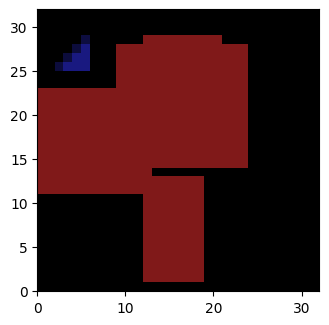

In [40]:
index = 0
show_image(imgs[index])

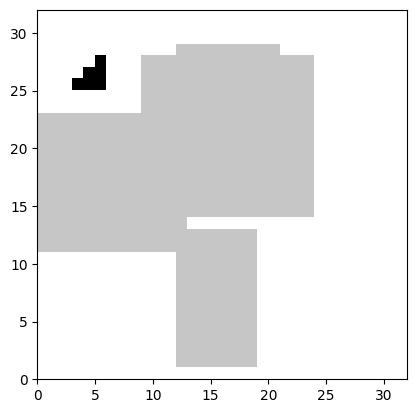

In [41]:
display_mask(masks[index])

# **Training model**

In [42]:
print(train_X.shape[1:])
model = model_segmentation(n_classes=4, img_shape=train_X.shape[1:])
model.compile('sgd', 'categorical_crossentropy')
model.fit(train_X, train_y, epochs=3, batch_size=32, validation_data=(test_X, test_y))

(32, 32, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 32, 32, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 32)   9248        dropout_3[0][0]                  
________________________________________________________________________________

# **Prediction and Evaluation**

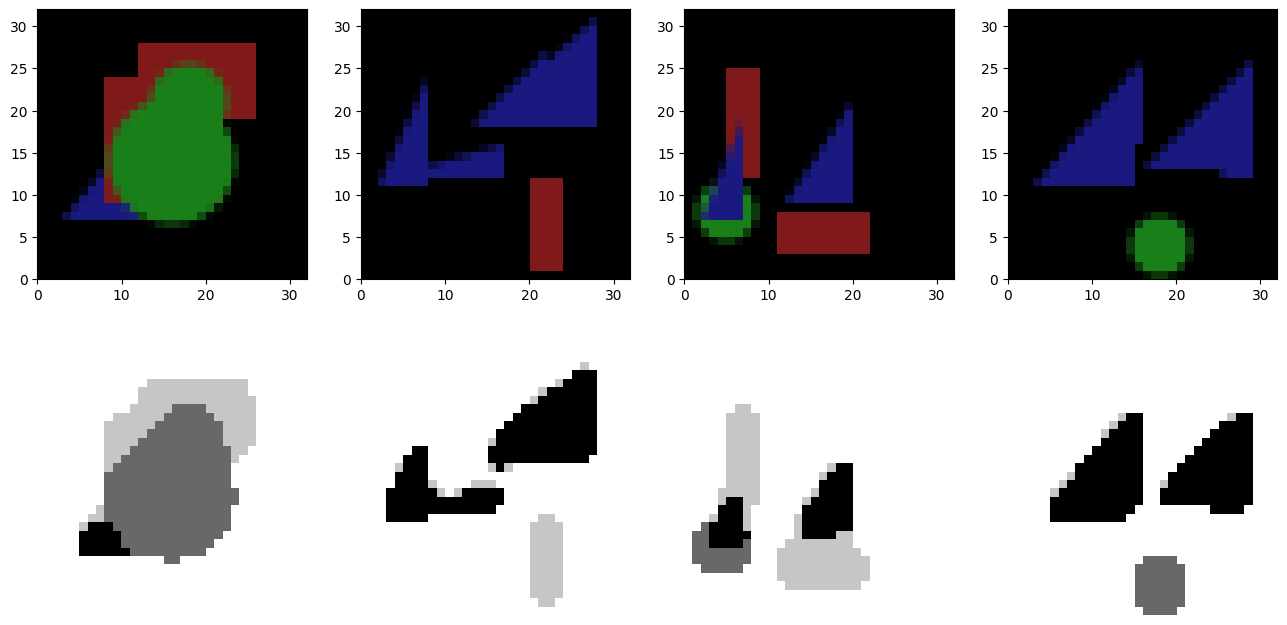

In [43]:
test_y_predicted = model.predict(test_X)

display(test_X, test_y_predicted)

# **Evaluation - mIoU**

In [44]:
# mIoU
import tensorflow as tf 
mIoU = tf.keras.metrics.MeanIoU(num_classes=4)

flatted_y_predicted = test_y_predicted.flatten()
flatted_y = test_y.flatten()

mIoU.update_state(test_y, flatted_y_predicted)
mIoU.result().numpy()

0.37993017

: 